<a href="https://colab.research.google.com/github/lmichan/BIOliteraturaPE203625/blob/main/Enlace_con_Zotero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de la Biblioteca Zotero - Biología 2025

Este cuaderno de Google Colab fue desarrollado por José Antonio Hernández Mondragón como parte del proyecto PAPIME PE203625.

El propósito principal de este código es realizar un análisis detallado de la biblioteca Zotero correspondiente al curso de Biología 2025, con el fin de extraer información relevante, identificar patrones de uso, temáticas predominantes y apoyar la toma de decisiones en la gestión y mejora de los recursos bibliográficos disponibles.

A lo largo del cuaderno se implementan herramientas de procesamiento de datos, visualización y análisis bibliométrico para obtener una visión integral del contenido y estructura de la biblioteca Zotero.

## Conexión entre Zotero y Google Colab

Para realizar el análisis de la biblioteca de Zotero desde Google Colab, es necesario establecer una conexión entre ambas plataformas utilizando la Zotero Web API. Esta API permite acceder a colecciones, referencias, metadatos y otros recursos almacenados en una cuenta o grupo de Zotero, lo cual facilita el procesamiento automatizado de los datos.

## Requisitos de configuración

Antes de comenzar el análisis, es necesario contar con dos elementos clave:

* Zotero API Key

* Group ID (en caso de trabajar con una biblioteca de grupo)

### 1. Zotero API Key

La API Key es una clave personal que otorga permisos para acceder a la biblioteca Zotero de forma segura. Para obtenerla, sigue estos pasos:

* Accede a tu cuenta en Zotero.org.

* Ve a Settings > Feeds/API.

* En la sección de API Keys, haz clic en Create new private key.

* Define los permisos de acceso (por ejemplo, lectura) y copia la clave generada.

* Esta clave se utilizará en el código para autenticar las solicitudes a la API.

### 2. Group ID

Si estás trabajando con una biblioteca de grupo, también necesitas el identificador único del grupo. Para obtenerlo:

* Ingresa al sitio de Zotero y selecciona tu grupo.

* El Group ID se encuentra en la URL del grupo. Por ejemplo, en: https://www.zotero.org/groups/1234567/nombre_del_grupo

* El número 1234567 es el Group ID que deberás usar.


In [124]:
# CONFIGURA TU CLAVE Y GROUP ID

import requests
from collections import defaultdict, Counter
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import random

# Si es necesario se instala la libreria.
# !pip install wordcloud matplotlib
!pip install pyspellchecker

# CONFIGURA TU CLAVE Y GROUP ID (Estos se obtienen en Zotero)
API_KEY = "l7nkDwrKLxASVprKSjbadbXs"
GROUP_ID = "5866354"
HEADERS = {"Zotero-API-Key": API_KEY}


In [125]:
API_KEY = "l7nkDwrKLxASVprKSjbadbXs"  # Tu clave
GROUP_ID = "5866354"
HEADERS = {"Zotero-API-Key": API_KEY}

items = []
url = f"https://api.zotero.org/groups/{GROUP_ID}/items?limit=100"

while url:
    response = requests.get(url, headers=HEADERS)
    if response.status_code != 200:
        print("❌ Error:", response.status_code)
        break

    data = response.json()
    if not data:
        break

    for item in data:
        if "data" in item:
            d = item["data"]
            tags = [t["tag"] for t in d.get("tags", [])]

            items.append({
                "titulo": d.get("title"),
                "fecha_publicacion": d.get("date"),  # 👈 Usa el año o fecha de publicación real
                "tipo": d.get("itemType"),
                "etiquetas": tags,
                "fecha": d.get("dateAdded") # 👈 Corrección aquí para usar la fecha de adición
            })

    # Manejo de paginación automática
    if "Link" in response.headers:
        links = response.headers["Link"].split(",")
        next_link = None
        for link in links:
            if 'rel="next"' in link:
                next_link = link[link.find("<")+1:link.find(">")]
        url = next_link
    else:
        url = None

# Crear DataFrame
df = pd.DataFrame(items)

La paleta de colores utilizada para este trabajo es Okabe-Ito fue propuesta por Okabe e Ito (2008) como una paleta de colores cualitativa accesible para personas con diversas deficiencias en la visión del color. Además de ser accesible, incluye nueve colores vivos y fáciles de identificar, que corresponden a los principales colores primarios y secundarios (p. ej., rojo, amarillo y azul).

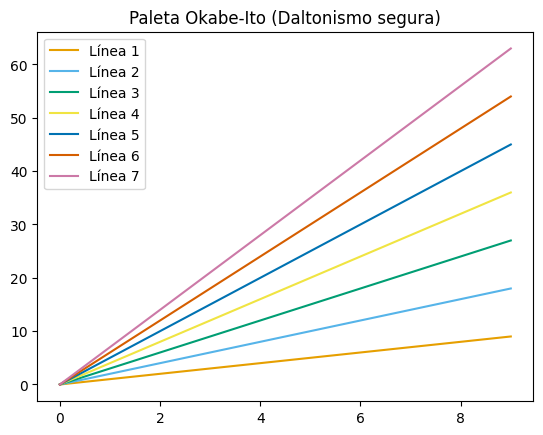

In [126]:
okabe_ito = [
    "#E69F00", # Orange
    "#56B4E9", # Sky Blue
    "#009E73", # Bluish Green
    "#F0E442", # Yellow
    "#0072B2", # Blue
    "#D55E00", # Vermilion
    "#CC79A7"  # Reddish Purple
]

plt.rcParams["axes.prop_cycle"] = plt.cycler(color=okabe_ito)

for i in range(7):
    plt.plot(range(10), [j*(i+1) for j in range(10)], label=f"Línea {i+1}")
plt.legend()
plt.title("Paleta Okabe-Ito (Daltonismo segura)")
plt.show()

## Gráfico de lineas publicaciones biblioteca por día.

Este código genera una gráfica de línea que muestra cómo van aumentando las publicaciones en tu biblioteca de Zotero a lo largo del tiempo.

Resumen de lo que se visualiza en la gráfica:

* Eje X (horizontal): las fechas (cada día en que se añadieron referencias a Zotero).
* Eje Y (vertical): la cantidad de publicaciones añadidas en esa fecha.
* Cada punto representa el número de ítems incorporados en un día específico.
* La línea une esos puntos, mostrando la tendencia temporal en la incorporación de referencias.
* Se incluyen marcadores y cuadrícula, lo que facilita identificar picos (días con muchas publicaciones) y periodos con baja o nula actividad.

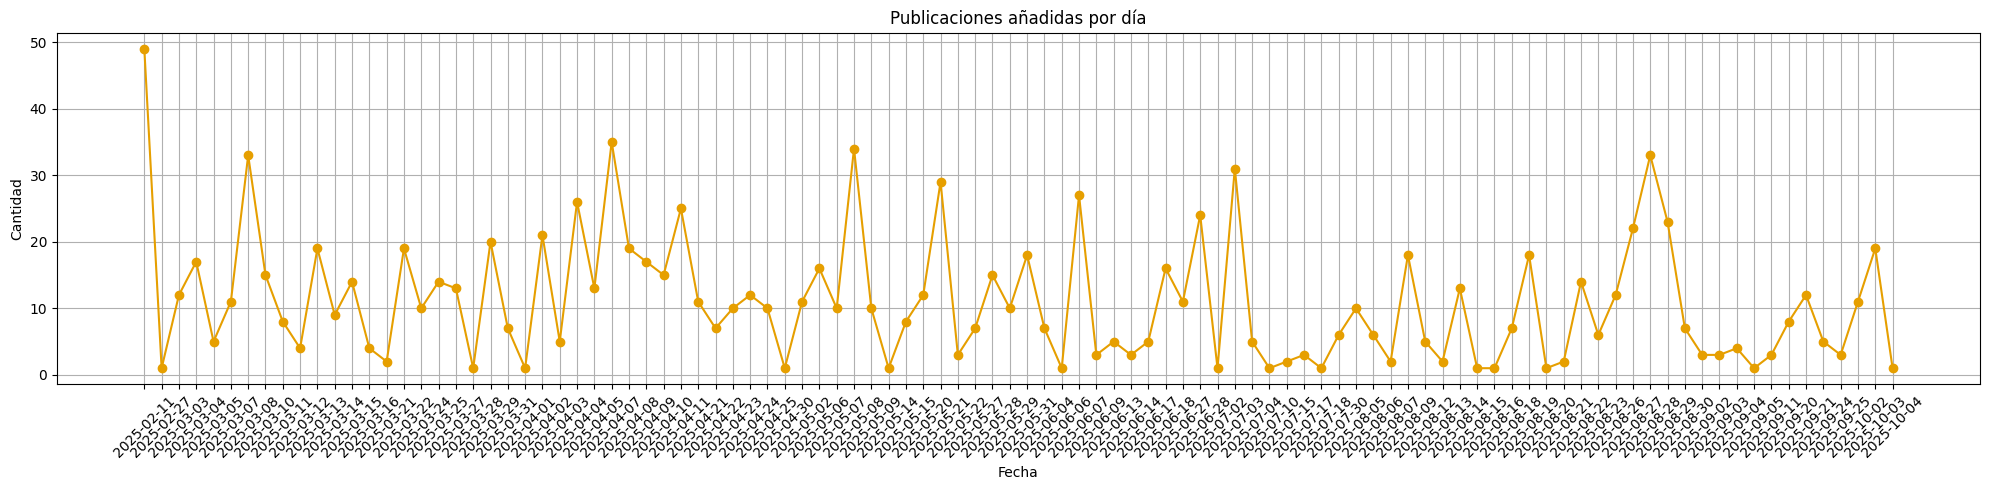

In [127]:
df = pd.DataFrame(items)
df["fecha"] = pd.to_datetime(df["fecha"])

# Agrupar por día
conteo_por_dia = df.groupby(df["fecha"].dt.date).size().reset_index(name="Total_Publicaciones")

# Opcional: convertir fechas a string para exportar
conteo_por_dia["fecha"] = conteo_por_dia["fecha"].astype(str)

# Generamos la grafica de publicaciones añadidas por día
plt.figure(figsize=(20, 5))
plt.plot(conteo_por_dia["fecha"], conteo_por_dia["Total_Publicaciones"], marker='o')
plt.xticks(rotation=45)
plt.title("Publicaciones añadidas por día")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.tight_layout()
plt.grid(True)
plt.show()

Al agrupar las publicaciones por semana en lugar de por día, la gráfica se vuelve más limpia y comprensible. En la visualización diaria se generan muchos puntos dispersos, lo que puede hacer difícil identificar tendencias claras debido a la variabilidad natural (algunos días se agregan muchas referencias y otros ninguna).

En cambio, la vista semanal suaviza esas fluctuaciones y muestra con mayor claridad los periodos de mayor o menor productividad en la incorporación de referencias. Esto permite:

* Detectar picos semanales de trabajo en la recopilación bibliográfica.

* Observar de manera más estable la tendencia general en el tiempo.

* Comparar semanas entre sí para identificar patrones de actividad (por ejemplo, semanas intensivas de búsqueda vs. semanas más tranquilas).

La visualización por semana reduce el ruido del día a día y resalta las tendencias globales, facilitando el análisis de la evolución de tu biblioteca Zotero.

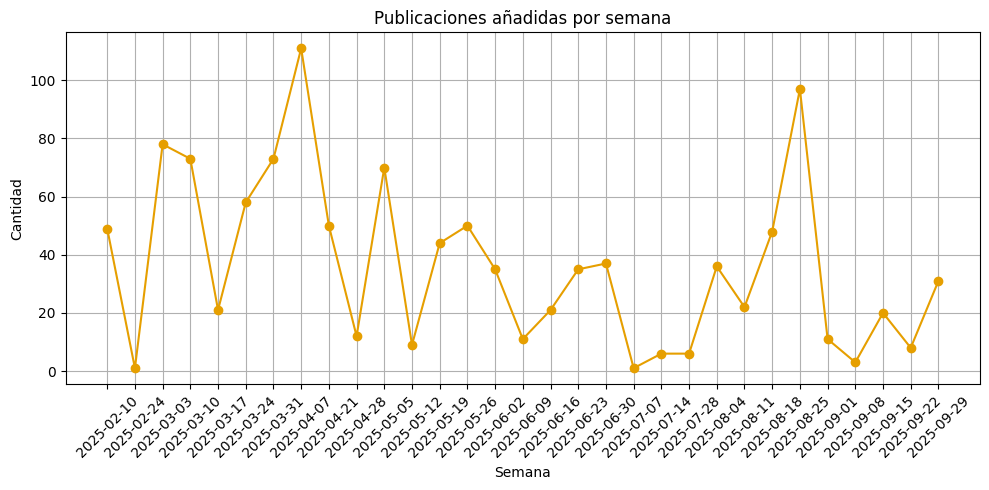

In [128]:
# Re-run the weekly graph cell to reflect the corrected 'fecha' data
# 🔹 Agrupar por semana
# Convertir la columna 'fecha' a datetime si aún no lo está
df["fecha"] = pd.to_datetime(df["fecha"])

# Eliminar la información de la zona horaria antes de convertir a período
df["fecha_sin_tz"] = df["fecha"].dt.tz_convert(None) if df["fecha"].dt.tz is not None else df["fecha"]

# Agrupar por semana (esto crea objetos tipo "2025-08-04/2025-08-10")
# Usamos dt.to_period('W').dt.start_time para obtener el inicio de la semana
df["semana"] = df["fecha_sin_tz"].dt.to_period("W").dt.start_time

# 🔹 Contar publicaciones por semana
conteo_semanal = df.groupby("semana").size().reset_index(name="Total_Publicaciones")

# 🔹 Convertir fechas para graficar o exportar
conteo_semanal["semana_str"] = conteo_semanal["semana"].dt.strftime("%Y-%m-%d")

# Vemos la grafica a nivel semanal
plt.figure(figsize=(10, 5))
plt.plot(conteo_semanal["semana_str"], conteo_semanal["Total_Publicaciones"], marker='o')
plt.xticks(rotation=45)
plt.title("Publicaciones añadidas por semana")
plt.xlabel("Semana")
plt.ylabel("Cantidad")
plt.grid(True)
plt.tight_layout()
plt.show()

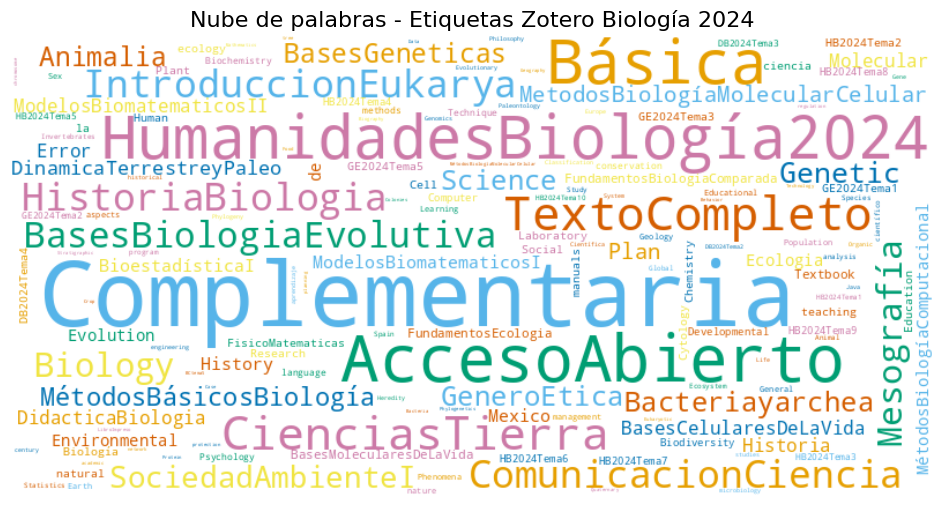

In [129]:
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(okabe_ito)

# Convertir todas las etiquetas en un solo string
text = ' '.join(all_tags)

# Crear la nube
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    color_func=color_func,
    collocations=False
).generate(text)

# Mostrar la nube
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de palabras - Etiquetas Zotero Biología 2024", fontsize=16)
plt.show()


Se realizo un análisis de los títulos de las referencias permitiendo garantizar la calidad y coherencia de la base bibliográfica. Dado que Zotero se usa frecuentemente para generar citas y bibliografías en documentos académicos, los errores en los títulos (como guiones mal colocados, uso incorrecto de mayúsculas, puntos innecesarios o faltas de ortografía) pueden trasladarse de forma automática a los artículos, tesis o reportes en los que se cite la fuente.

Este proceso de revisión y limpieza tiene varias ventajas:

* Coherencia formal: asegura que todos los títulos sigan el mismo estilo de escritura, evitando inconsistencias que afectan la presentación profesional del trabajo.

* Evitar errores en citas automáticas: al corregir la ortografía y el formato, se reducen fallos al exportar bibliografías en estilos como APA, MLA o Vancouver.

* Ahorro de tiempo: una biblioteca limpia significa menos correcciones manuales al final de un proyecto.

* Mayor credibilidad académica: las referencias son parte fundamental de cualquier investigación, y tener títulos bien escritos refleja rigurosidad y cuidado en el trabajo científico.

En síntesis, este análisis convierte la biblioteca de Zotero en una fuente depurada y confiable, lista para integrarse directamente en publicaciones sin arrastrar errores tipográficos o de estilo.

In [130]:
import pandas as pd
import re
from spellchecker import SpellChecker

# Diccionarios español e inglés
spell_es = SpellChecker(language='es')
spell_en = SpellChecker(language='en')

problemas = []

for titulo in df["titulo"].dropna():
    errores = []

    palabras = titulo.split()

    # 1. Regla APA: solo la primera palabra debe estar capitalizada (excepto nombres propios, aquí no los distinguimos)
    for i, word in enumerate(palabras):
        if i == 0:  # primera palabra
            continue
        elif word[0].isupper():  # palabra con mayúscula inicial que no debería
            errores.append("MAYÚSCULAS APA")
            break

    # 2. Punto final
    if titulo.strip().endswith("."):
        errores.append("PUNTO FINAL APA")

    # 3. Espacios dobles
    if "  " in titulo:
        errores.append("ESPACIOS DOBLES")

    # 4. Guiones
    if "-" in titulo:
        errores.append("GUIONES")

    # 5. Corchetes
    if "[" in titulo or "]" in titulo:
        errores.append("CORCHETES")

    # 6. Símbolos especiales
    if re.search(r"[@#\$%\^&\*\~\=]", titulo):
        errores.append("SÍMBOLOS ESPECIALES")

    # 7. Ortografía (es/en)
    palabras_limpias = re.findall(r'\b\w+\b', titulo.lower())
    errores_ort = []
    for p in palabras_limpias:
        if p not in spell_es and p not in spell_en:
            errores_ort.append(p)

    if len(errores_ort) >= 2:
        errores.append("ORTOGRAFÍA")

    # Guardar si hay errores
    if errores:
        problemas.append({"titulo": titulo, "errores": ", ".join(errores)})

df_errores = pd.DataFrame(problemas)
print(f"🔎 Títulos problemáticos encontrados (APA): {len(df_errores)}")
df_errores.head(10)



🔎 Títulos problemáticos encontrados (APA): 522


,titulo,errores
0,Non-linearity in population ecology,GUIONES
1,Modelos estadisticos lineales : interpretacion...,ORTOGRAFÍA
2,Modelos estadísticos lineales: interpretació...,ORTOGRAFÍA
3,An Analysis of Variance Test for Normality (Co...,MAYÚSCULAS APA
4,Introductory Biological Statistics: Fourth Edi...,MAYÚSCULAS APA
5,Introducción a la bioestadística,ORTOGRAFÍA
6,"Uso correcto, parcial e incorrecto de los térm...",ORTOGRAFÍA
7,Estadística,ORTOGRAFÍA
8,Diseño y análisis de experimentos,ORTOGRAFÍA
9,El Protocolo de investigación: lineamientos p...,"MAYÚSCULAS APA, ORTOGRAFÍA"


                                              titulo fecha_publicacion     año
0                Non-linearity in population ecology              2014  2014.0
1                                               None              None     NaN
2  Modelos estadisticos lineales : interpretacion...              1976  1976.0
3  Modelos estadísticos lineales: interpretació...              1981  1981.0
4                            Biostatistical analysis              2014  2014.0


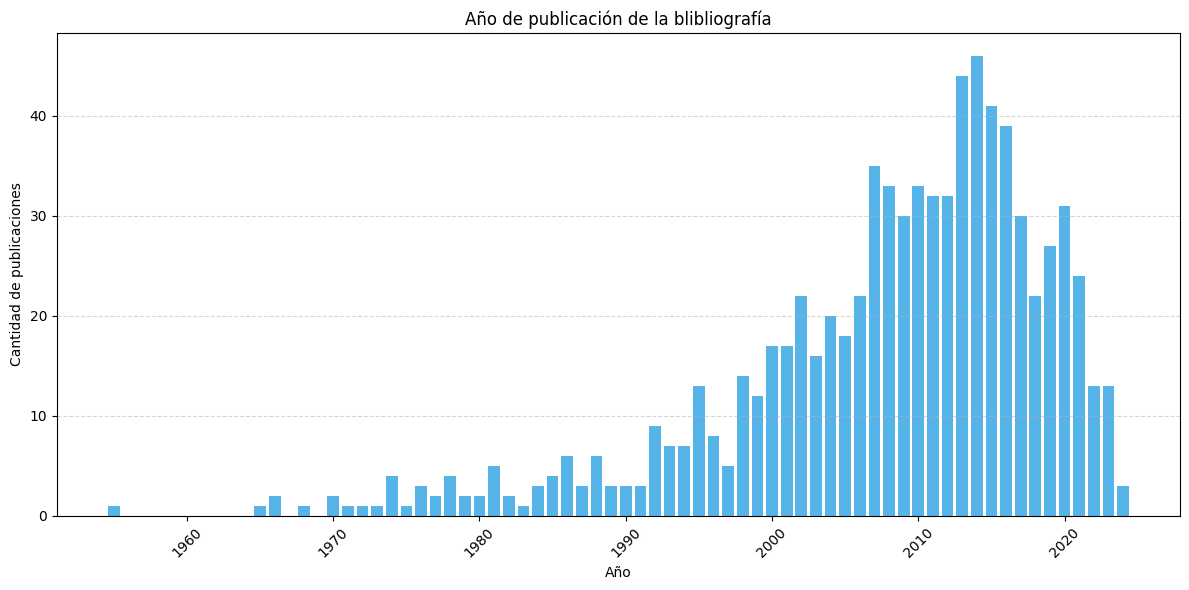

In [131]:
import re
import numpy as np

def extraer_anio(fecha_texto):
    if not isinstance(fecha_texto, str):
        return np.nan
    match = re.search(r"\b(19|20)\d{2}\b", fecha_texto)
    return int(match.group()) if match else np.nan

df["año"] = df["fecha_publicacion"].apply(extraer_anio)

print(df[["titulo", "fecha_publicacion", "año"]].head())

conteo_por_anio = df["año"].value_counts().sort_index().reset_index()
conteo_por_anio.columns = ["Año", "Cantidad"]
conteo_por_anio = conteo_por_anio[conteo_por_anio["Año"].notnull()]  # Filtrar nulos
conteo_por_anio["Año"] = conteo_por_anio["Año"].astype(int)
conteo_por_anio

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(conteo_por_anio["Año"], conteo_por_anio["Cantidad"], color="#56B4E9")
plt.title("Año de publicación de la blibliografía")
plt.xlabel("Año")
plt.ylabel("Cantidad de publicaciones")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipython-input-88572185.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_validos["edad"] = anio_actual - df_validos["año"]


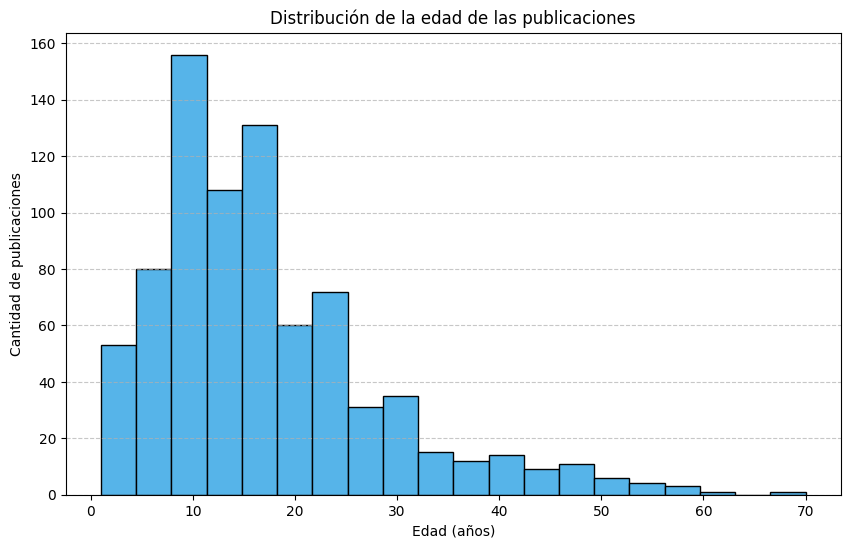

In [132]:
from datetime import datetime

anio_actual = datetime.now().year

# Filtramos filas con año válido
df_validos = df[df["año"].notnull()]

# Calculamos edad de cada publicación
df_validos["edad"] = anio_actual - df_validos["año"]

# Vemos los primeros
df_validos.head()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(df_validos["edad"], bins=20, color="#56B4E9", edgecolor="black")
plt.title("Distribución de la edad de las publicaciones")
plt.xlabel("Edad (años)")
plt.ylabel("Cantidad de publicaciones")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [133]:
# Edad promedio de la libreria.
edad_promedio = df_validos["edad"].mean()
print(f"La edad promedio de las publicaciones es de {edad_promedio:.2f} años.")

La edad promedio de las publicaciones es de 17.13 años.


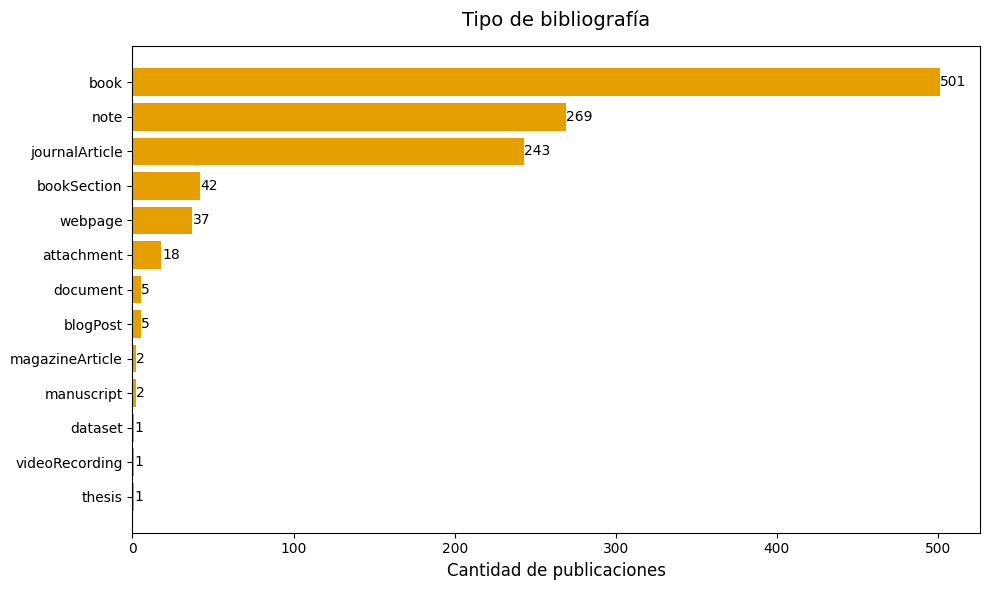

In [134]:
# ============================
# 📊 Gráfica de barras: Tipos de ítems Zotero
# ============================

if "tipo" in df.columns:
    # Contar los tipos de ítem
    conteo_tipos = df["tipo"].value_counts().sort_values()

    # Paleta accesible (Okabe-Ito)
    okabe_ito = [
        "#E69F00"
    ]

    # Crear la gráfica
    plt.figure(figsize=(10, 6))
    bars = plt.barh(
        conteo_tipos.index,
        conteo_tipos.values,
        color=okabe_ito[:len(conteo_tipos)]
    )

    # Etiquetas y estilo
    plt.title("Tipo de bibliografía", fontsize=14, pad=15)
    plt.xlabel("Cantidad de publicaciones", fontsize=12)
    plt.ylabel("", fontsize=12)

    # Añadir etiquetas de valor al final de cada barra
    for bar in bars:
        plt.text(
            bar.get_width() + 0.3,                 # posición x
            bar.get_y() + bar.get_height() / 2,    # posición y
            str(int(bar.get_width())),              # texto (conteo)
            va="center", ha="left", fontsize=10
        )

    plt.tight_layout()
    plt.show()

else:
    print("⚠️ No se encontró la columna 'tipo'. Asegúrate de incluir item_data.get('itemType') en el diccionario.")




/tmp/ipython-input-957849245.py:46: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-957849245.py:46: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-957849245.py:46: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_

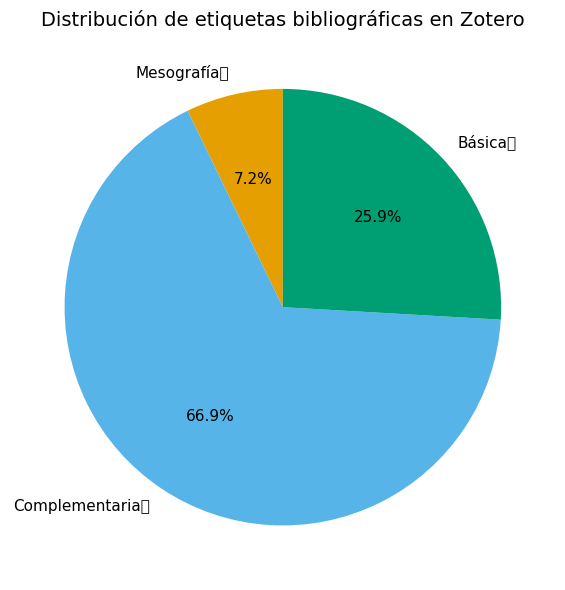

In [135]:
# ============================
# 🥧 Gráfica de pastel: etiquetas de tipo bibliografía
# ============================

import pandas as pd
import matplotlib.pyplot as plt

# Paleta Okabe-Ito (segura para daltónicos)
okabe_ito = [
    "#E69F00",  # Orange
    "#56B4E9",  # Sky Blue
    "#009E73",  # Bluish Green
    "#F0E442",  # Yellow
    "#0072B2",  # Blue
    "#D55E00",  # Vermilion
    "#CC79A7"   # Reddish Purple
]

# Etiquetas a analizar
etiquetas_objetivo = ["Mesografía🟡", "Complementaria🟢", "Básica🔵"]

# Contar cuántas veces aparece cada una
conteo_etiquetas = {et: 0 for et in etiquetas_objetivo}

for etiquetas in df["etiquetas"]:
    if isinstance(etiquetas, list):
        for e in etiquetas:
            if e in conteo_etiquetas:
                conteo_etiquetas[e] += 1
    elif isinstance(etiquetas, str):
        for et in etiquetas_objetivo:
            if et in etiquetas:
                conteo_etiquetas[et] += 1

# Crear gráfica
plt.figure(figsize=(6, 6))
plt.pie(
    conteo_etiquetas.values(),
    labels=conteo_etiquetas.keys(),
    autopct="%1.1f%%",
    startangle=90,
    colors=okabe_ito[:len(conteo_etiquetas)],
    textprops={"fontsize": 11}
)
plt.title("Distribución de etiquetas bibliográficas en Zotero", fontsize=14)
plt.tight_layout()
plt.show()
